In [5]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns

In [6]:
# Database connection parameters
db_params = {
    'dbname': 'integration',
    'user': 'postgres',
    'password': '1234',
    'host': 'localhost',
    'port': '5432'
}

In [7]:
# Establishing the connection
conn = psycopg2.connect(**db_params)

# Define your SQL query
query = "SELECT * FROM db_events;"

# Execute the query and store the result in a pandas DataFrame
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Display the DataFrame
print(df.head())

C:\Users\Zephyrus\AppData\Local\Temp\ipykernel_12068\3958174467.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


   duracion       fecha  hora  esquema                tabla  \
0        38  2024-06-01     0  sat_fel  p_dte_emisor_gtq_ag   
1        42  2024-06-01     0  sat_fel  p_dte_emisor_gtq_ag   
2        27  2024-06-01     0  sat_fel  p_dte_emisor_gtq_ag   
3        15  2024-06-01     0  sat_fel  p_dte_emisor_gtq_ag   
4        21  2024-06-01     0  sat_fel  p_dte_emisor_gtq_ag   

                                    app  Day of month  ID Day of week  \
0  2ff814a6-3304-4ab8-85cb-cd0e6f879c1d             1               7   
1  2ff814a6-3304-4ab8-85cb-cd0e6f879c1d             1               7   
2  2ff814a6-3304-4ab8-85cb-cd0e6f879c1d             1               7   
3  2ff814a6-3304-4ab8-85cb-cd0e6f879c1d             1               7   
4  2ff814a6-3304-4ab8-85cb-cd0e6f879c1d             1               7   

  Day of week    mean_st  ...  rango_final_by_table  tamañano_resp_by_table  \
0      sábado  28.165406  ...          7.980910e+07            2.439692e+06   
1      sábado  28.165406

In [8]:
d_row = df[df['pre_clasificacion'] == 'NORMAL']

# Randomly select 50% of those rows
np.random.seed(0)  # For reproducibility
sample_rows_d = d_row.sample(frac=0.7) #0.7

# Drop the selected rows from the original DataFrame
df = df.drop(sample_rows_d.index)

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

selected_cols = df[[ 'tabla','app','Day of month','ID Day of week'
       ,'Evento del Dia','SimultJobs','latencia_by_day_month',
       'latencia_by_day_week','pre_clasificacion']]

categorical_columns = ['tabla', 'Evento del Dia','app']
numeric_columns = ['ID Day of week','SimultJobs','Day of month','latencia_by_day_month','latencia_by_day_week']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(), categorical_columns),
        ('num', StandardScaler(), numeric_columns)
    ])


encoded_data = preprocessor.fit_transform(selected_cols)

X = encoded_data
y = selected_cols['pre_clasificacion']

y_encoded = pd.get_dummies(y).values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y)

In [6]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout, BatchNormalization


In [7]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(y_encoded.shape[1], activation='softmax')
])

In [8]:
# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
35884/35884 [==============================] - 137s 4ms/step - loss: 0.6527 - accuracy: 0.6307 - val_loss: 0.6315 - val_accuracy: 0.6570
Epoch 2/20
35884/35884 [==============================] - 132s 4ms/step - loss: 0.6432 - accuracy: 0.6435 - val_loss: 0.6267 - val_accuracy: 0.6589
Epoch 3/20
35884/35884 [==============================] - 134s 4ms/step - loss: 0.6412 - accuracy: 0.6458 - val_loss: 0.6281 - val_accuracy: 0.6588
Epoch 4/20
35884/35884 [==============================] - 135s 4ms/step - loss: 0.6395 - accuracy: 0.6470 - val_loss: 0.6293 - val_accuracy: 0.6592
Epoch 5/20
35884/35884 [==============================] - 136s 4ms/step - loss: 0.6383 - accuracy: 0.6482 - val_loss: 0.6263 - val_accuracy: 0.6592
Epoch 6/20
35884/35884 [==============================] - 156s 4ms/step - loss: 0.6374 - accuracy: 0.6495 - val_loss: 0.6277 - val_accuracy: 0.6545
Epoch 7/20
35884/35884 [==============================] - 114s 3ms/step - loss: 0.6374 - accuracy: 0.6495 - val_

In [10]:

# Predict for the test data
predictions = model.predict(X_test)

In [11]:
binary_predictions = np.array(predictions) > 0.5
binary_predictions = binary_predictions.astype(int)
binary_predictions

array([[1, 0],
       [0, 1],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [1, 0]])

In [12]:
pred = []

for i in binary_predictions:
    if i[0] == 1:
        pred.append(0)
    else:
        pred.append(1)

In [13]:
true_labels = np.array(y_test, dtype=int)
true_labels

array([[1, 0],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [1, 0],
       [1, 0]])

In [14]:
true_y = []

for i in true_labels:
    if i[0] == 1:
        true_y.append(0)
    else:
        true_y.append(1)

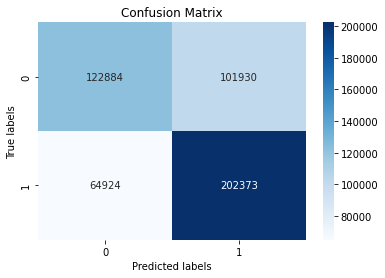

In [15]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_y, pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [16]:
accuracy = accuracy_score(true_y, pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 66.09%


In [19]:
from sklearn.metrics import classification_report
report = classification_report(true_y, pred, target_names=['Normal','Tardado'])
print(report)

              precision    recall  f1-score   support

      Normal       0.65      0.55      0.60    224814
     Tardado       0.67      0.76      0.71    267297

    accuracy                           0.66    492111
   macro avg       0.66      0.65      0.65    492111
weighted avg       0.66      0.66      0.66    492111



In [17]:
model.save('cnn_clas.h5')

In [18]:
from keras.models import load_model
model = load_model('cnn_clas.h5')